<a href="https://colab.research.google.com/github/christophermoverton/hotel-review-sentiment-modeling/blob/main/roberta_hotel_review_rating_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Hotel Review Sentiment Classification Using RoBERTa

## Introduction

Hotels and hospitality services play a central role in the travel, recreation, and leisure industries. Digital platforms such as TripAdvisor have become essential tools for consumers, providing accessible information, peer evaluations, and rating systems that influence hotel selection decisions. As a result, customer feedback—both in the form of numerical ratings and written reviews—plays a significant role in shaping consumer perceptions and guiding purchasing behavior.

Given the importance of user-generated feedback, analyzing the relationship between review text and corresponding ratings offers valuable insight into how consumers evaluate their hotel experiences. Sentiment and rating analysis can help hospitality providers better understand drivers of satisfaction and dissatisfaction, identify operational pain points, and detect mismatches between expressed sentiment and assigned ratings.

This study begins by establishing a baseline RoBERTa transformer model to predict hotel ratings (scaled ordinally from 1 to 5) based on review text. We evaluate baseline performance and then introduce class weighting to assess whether correcting for class imbalance (identified during exploratory data analysis) improves model outcomes. Next, we reframe the task into a three-class structure (low, mid, high) to examine whether reducing ordinal granularity enhances separability and predictive stability relative to the baseline. Finally, we analyze transformer-based embeddings within the three-class framework and apply comparative clustering techniques to investigate how sentiment signals align—or diverge—across rating categories.




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After mounting, specify the path to your file. For example:

In [3]:
import pandas as pd
file_path = '/content/drive/My Drive/tripadvisor_classification_folder/tripadvisor_hotel_reviews.csv'
df = pd.read_csv(file_path)
display(df.head())

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


/tmp/ipython-input-1592798567.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


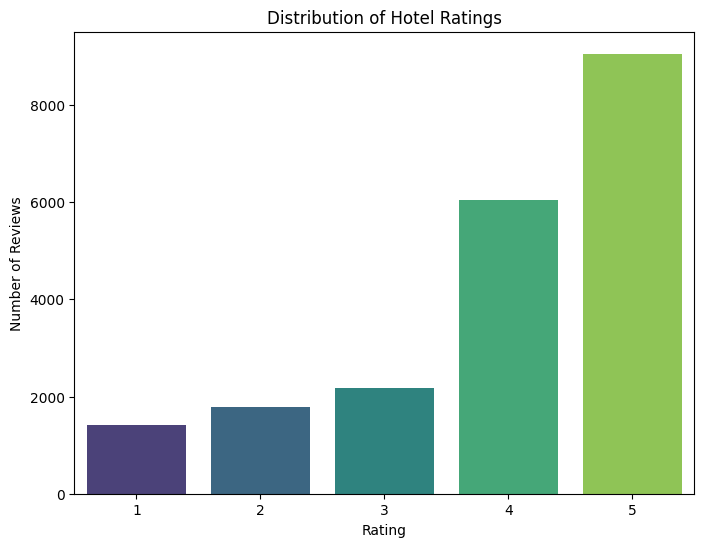

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribution of Hotel Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

There is a fairly sizable class imbalance shown for the different review categories.  Most notably, reviews tend to be predominantly positive, whereas ratings at 3 and below are no morre than 6000 reviews which equals the number of reviews for rating 4 reviews.  Rating 5 predominates with well over 8000 reviews.

In [5]:
df[['Review', 'Rating']].isna().sum()

,0
Review,0
Rating,0


No missing values were detected in the Review or Rating columns.

## Modeling Customer Sentiment Review Language for Star Ratings



### Modeling description

1. **Data preparation**

   * Starts from a pandas dataframe containing two fields: `Review` (text) and `Rating` (integer 1–5).
   * Cleans the data by removing missing/empty reviews and restricting ratings to the valid range (1–5).
   * Performs an **80/20 stratified train–validation split** to preserve the rating distribution across splits.

2. **Label engineering**

   * Converts ratings from **1–5** into **0–4** to match the expected label indexing for cross-entropy classification in Transformers (`labels = Rating - 1`).

3. **Tokenization**

   * Uses the `roberta-base` tokenizer to convert review text into model inputs (`input_ids`, `attention_mask`).
   * Applies truncation to a maximum length of **256 tokens** to control memory and training cost.
   * Uses a dynamic padding collator (`DataCollatorWithPadding`) so batches are padded efficiently at runtime.

4. **Model**

   * Loads `roberta-base` with a **5-class sequence classification head** (`num_labels=5`).
   * The model learns to map the review text to one of five rating classes.

5. **Training configuration**

   * Fine-tunes for **3 epochs** using AdamW-style optimization with:

     * learning rate **2e-5**
     * weight decay **0.01**
     * warmup ratio **0.06**
   * Evaluates once per epoch and saves checkpoints per epoch.
   * Automatically restores the best checkpoint at the end based on **validation macro-F1**.
   * Uses mixed precision (`fp16`) if a CUDA GPU is available.

6. **Evaluation**

   * Computes:

     * **Accuracy**
     * **Macro F1** (treats each rating class equally, useful under imbalance)
   * After training, generates predictions on the validation set and reports:

     * a **confusion matrix** (true vs predicted star ratings)
     * a **classification report** (precision/recall/F1 per star rating)

In short: this is a **RoBERTa-based 5-class rating prediction model** trained on review text, evaluated with both overall performance metrics and class-level diagnostics to highlight where ordinal confusion occurs (especially in mid-range ratings).


In [7]:
# pip install -q transformers datasets scikit-learn accelerate torch

import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

set_seed(42)

# --- assumes you already have a pandas df with columns: Review, Rating ---
df = df.copy()

# Clean
df["Review"] = df["Review"].astype(str).str.strip()
df = df[df["Review"].notna() & (df["Review"] != "") & df["Rating"].notna()]
df["Rating"] = df["Rating"].astype(int)
df = df[df["Rating"].between(1, 5)]

# Train/val split (stratified)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Rating"]
)

# HF datasets
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

# Map 1–5 -> 0–4 into REQUIRED column name: "labels"
def add_labels(ex):
    ex["labels"] = int(ex["Rating"]) - 1
    return ex

train_ds = train_ds.map(add_labels)
val_ds   = val_ds.map(add_labels)

# Tokenize
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["Review"], truncation=True, max_length=256)

train_ds = train_ds.map(tok, batched=True)
val_ds   = val_ds.map(tok, batched=True)

# Keep only what Trainer needs
keep = {"input_ids", "attention_mask", "labels"}
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names   if c not in keep])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Metrics
def compute_metrics(eval_pred):
    # works across Trainer API variants
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

# fp16 only if CUDA is available
try:
    import torch
    use_fp16 = torch.cuda.is_available()
except Exception:
    use_fp16 = False

# Training args: support BOTH old and new transformers (eval_strategy vs evaluation_strategy)
args_kwargs = dict(
    output_dir="roberta_reviews_star_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.06,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    fp16=use_fp16,
    report_to="none",
)

try:
    args = TrainingArguments(**args_kwargs, eval_strategy="epoch")
except TypeError:
    args = TrainingArguments(**args_kwargs, evaluation_strategy="epoch")

# Trainer: DO NOT pass tokenizer (your version doesn't accept it)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate + confusion matrix on val
pred = trainer.predict(val_ds)
val_logits = pred.predictions
val_labels = pred.label_ids
val_preds  = np.argmax(val_logits, axis=-1)

stars_true = val_labels + 1
stars_pred = val_preds + 1

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(stars_true, stars_pred, labels=[1,2,3,4,5]))

print("\nClassification Report:")
print(classification_report(stars_true, stars_pred, labels=[1,2,3,4,5], digits=4))


Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.768347,0.747038,0.676263,0.596107
2,0.657474,0.743354,0.678214,0.621340
3,0.586824,0.749559,0.681874,0.635053


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Confusion Matrix (rows=true, cols=pred):
[[ 216   65    1    2    0]
 [  61  199   79   17    3]
 [   6   85  190  144   12]
 [   1    8  101  724  374]
 [   0    2   11  332 1466]]

Classification Report:
              precision    recall  f1-score   support

           1     0.7606    0.7606    0.7606       284
           2     0.5543    0.5543    0.5543       359
           3     0.4974    0.4348    0.4640       437
           4     0.5939    0.5993    0.5966      1208
           5     0.7903    0.8095    0.7998      1811

    accuracy                         0.6819      4099
   macro avg     0.6393    0.6317    0.6351      4099
weighted avg     0.6785    0.6819    0.6799      4099



F1-scores are strongest for the extreme rating categories (low and high), whereas performance degrades considerably for the mid-range category. This pattern may reflect class imbalance effects, but more likely indicates weaker sentiment segmentation in mid-level reviews, where linguistic signals are inherently more ambiguous and less discriminative.



Let's use a class weighting strategy to see if model f1-scores might improve

In [8]:
# pip install -q transformers datasets scikit-learn accelerate torch

import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

set_seed(42)

# --- assumes you already have a pandas df with columns: Review, Rating ---
df = df.copy()

# Clean
df["Review"] = df["Review"].astype(str).str.strip()
df = df[df["Review"].notna() & (df["Review"] != "") & df["Rating"].notna()]
df["Rating"] = df["Rating"].astype(int)
df = df[df["Rating"].between(1, 5)]

# Train/val split (stratified)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Rating"]
)

# ---- class weights from TRAIN labels (0..4) ----
train_labels_np = (train_df["Rating"].astype(int) - 1).to_numpy()
counts = np.bincount(train_labels_np, minlength=5)
# inverse-frequency-ish weights; stable + commonly used
weights_np = counts.sum() / (len(counts) * np.maximum(counts, 1))
# normalize to mean=1 (optional but nice)
weights_np = weights_np / weights_np.mean()

import torch
from torch import nn
class_weights = torch.tensor(weights_np, dtype=torch.float)

# HF datasets
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

def add_labels(ex):
    ex["labels"] = int(ex["Rating"]) - 1
    return ex

train_ds = train_ds.map(add_labels)
val_ds   = val_ds.map(add_labels)

# Tokenize
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["Review"], truncation=True, max_length=256)

train_ds = train_ds.map(tok, batched=True)
val_ds   = val_ds.map(tok, batched=True)

# Keep only what Trainer needs
keep = {"input_ids", "attention_mask", "labels"}
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names   if c not in keep])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Metrics
def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

# Custom Trainer with weighted cross-entropy
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# fp16 only if CUDA is available
use_fp16 = torch.cuda.is_available()

# Training args: supports both eval_strategy and evaluation_strategy
args_kwargs = dict(
    output_dir="roberta_reviews_star_model_weighted",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.06,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    fp16=use_fp16,
    report_to="none",
)

try:
    args = TrainingArguments(**args_kwargs, eval_strategy="epoch")
except TypeError:
    args = TrainingArguments(**args_kwargs, evaluation_strategy="epoch")

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

trainer.train()

# Evaluate + confusion matrix on val
pred = trainer.predict(val_ds)
val_logits = pred.predictions
val_labels = pred.label_ids
val_preds  = np.argmax(val_logits, axis=-1)

stars_true = val_labels + 1
stars_pred = val_preds + 1

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(stars_true, stars_pred, labels=[1,2,3,4,5]))

print("\nClassification Report:")
print(classification_report(stars_true, stars_pred, labels=[1,2,3,4,5], digits=4))


Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.894318,0.867787,0.663333,0.615826
2,0.750974,0.861890,0.648695,0.615531
3,0.704374,0.909359,0.659673,0.626858


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Confusion Matrix (rows=true, cols=pred):
[[ 218   63    2    1    0]
 [  64  200   82   10    3]
 [   5   98  221  103   10]
 [   1   10  180  730  287]
 [   0    4   20  452 1335]]

Classification Report:
              precision    recall  f1-score   support

           1     0.7569    0.7676    0.7622       284
           2     0.5333    0.5571    0.5450       359
           3     0.4376    0.5057    0.4692       437
           4     0.5633    0.6043    0.5831      1208
           5     0.8165    0.7372    0.7748      1811

    accuracy                         0.6597      4099
   macro avg     0.6215    0.6344    0.6269      4099
weighted avg     0.6726    0.6597    0.6647      4099



The degraded F1 performance in the middle-tier category suggests structural ambiguity rather than simple model deficiency. Mid-range reviews often contain mixed or attenuated sentiment signals, where textual polarity does not cleanly correspond to the assigned ordinal rating. Reviewers may downgrade without explicit negative language or, alternatively, provide critical commentary while still assigning a moderate score. This sentiment–rating miscalibration diminishes class separability and weakens predictive performance for the mid category.

We can reframe the task into a three-class rating system that maintains distinct high and low performance categories while collapsing mid-range ratings into a single class. While this approach sacrifices some classification nuance, it reduces ordinal noise and enhances model stability by acknowledging the inherent ambiguity of mid-tier sentiment signals.

In [4]:
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

set_seed(42)

df = df.copy()

df["Review"] = df["Review"].astype(str).str.strip()
df = df[df["Review"].notna() & (df["Review"] != "") & df["Rating"].notna()]
df["Rating"] = df["Rating"].astype(int)
df = df[df["Rating"].between(1,5)]

# 3-class mapping: Low(1-2)= 0, mid(3) = 1, high(4-5) = 2

def to_3class(r):
  if r <= 2:
    return 0
  elif r == 3:
    return 1
  else:
    return 2

df["y3"] = df["Rating"].apply(to_3class).astype(int)

#stratified split on the new label

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["y3"]
)

# hf datasets
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

def add_labels(ex):
  ex["labels"] = int(ex["y3"])
  return ex

train_ds = train_ds.map(add_labels)
val_ds   = val_ds.map(add_labels)

#tokenize
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tok(batch):
  return tokenizer(batch["Review"], truncation=True, max_length=256)

train_ds = train_ds.map(tok, batched=True)
val_ds = val_ds.map(tok, batched=True)

#keep only trainer columns
keep = {"input_ids", "attention_mask", "labels"}
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep])
val_ds  = val_ds.remove_columns([c for c in val_ds.column_names if c not in keep])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Model: 3 classes
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

# Metrics (macro-F1 is key with imbalance)
def compute_metrics(eval_pred):
  logits = eval_pred.predictions
  labels = eval_pred.label_ids
  preds = np.argmax(logits, axis=-1)
  return {
      "accuracy": accuracy_score(labels, preds),
      "macro_f1": f1_score(labels, preds, average="macro"),
  }

#fp16 only if CUDA is available
import torch
use_fp16 = torch.cuda.is_available()

# TrainingArguments: handle new vs old API
args_kwargs = dict(
    output_dir="roberta_reviews_3class",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.06,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=50,
    fp16=use_fp16,
    report_to="none",
)

try:
  args = TrainingArguments(**args_kwargs, eval_strategy="epoch")
except TypeError:
  args = TrainingArguments(**args_kwargs, evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

#evaluate + confusion matrix
pred = trainer.predict(val_ds)
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=-1)

# Pretty labels for reporting
label_names = ["low(1-2)", "mid(3)", "high(4-5)"]

print("Confusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred, labels=[0,1,2]))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))


Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
classifier.out_proj.weight      | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.338914,0.310330,0.882898,0.721370
2,0.274290,0.301369,0.884362,0.746088
3,0.172962,0.342448,0.882410,0.757658


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

Confusion Matrix (rows=true, cols=pred):
[[ 530   97   16]
 [  73  212  152]
 [  22  122 2875]]

Classification Report:
              precision    recall  f1-score   support

    low(1-2)     0.8480    0.8243    0.8360       643
      mid(3)     0.4919    0.4851    0.4885       437
   high(4-5)     0.9448    0.9523    0.9485      3019

    accuracy                         0.8824      4099
   macro avg     0.7616    0.7539    0.7577      4099
weighted avg     0.8813    0.8824    0.8818      4099





#### Observations

**High class (4–5):**
F1 ≈ 0.95, demonstrating very strong separability with minimal catastrophic errors (very few high → low misclassifications).

**Low class (1–2):**
F1 ≈ 0.84, also indicating a strong and relatively well-defined sentiment signal.

**Mid class (3):**
F1 ≈ 0.50, which is expected given the linguistic ambiguity inherent to three-star ratings.

The weaker performance in the mid class does not necessarily reflect model deficiency; rather, it appears to capture the underlying subjectivity embedded within the rating system itself. A “middle” rating is inherently relative—what constitutes a neutral experience for one reviewer may be perceived as mildly positive or mildly negative by another.

From a sentiment perspective, consumers who feel clearly satisfied are more likely to assign higher ratings, while clearly dissatisfied consumers gravitate toward lower ratings. The mid category, however, often reflects mixed or attenuated sentiment—reviews that contain both positive and negative elements without a dominant polarity. The ambiguity arises not from a lack of signal, but from competing signals within the same review, making class boundaries less distinct and inherently more difficult to model.




### Extract RoBERTa Embeddings

Let's grab some consumer insights from our ratings model.

### Save the model and tokenizer

In [5]:
# Define the directory to save the model
save_directory = "./my_fine_tuned_roberta_model"

# Save the model and tokenizer using the trainer
trainer.save_model(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model and tokenizer saved to ./my_fine_tuned_roberta_model


### Load the saved model and tokenizer

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Define the directory where the model was saved
loaded_model_directory = "./my_fine_tuned_roberta_model"

# Load the tokenizer
loaded_tokenizer = AutoTokenizer.from_pretrained(loaded_model_directory)

# Load the model
loaded_model = AutoModelForSequenceClassification.from_pretrained(loaded_model_directory)

# Move the loaded model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
#loaded_model.eval() # Set the model to evaluation mode

print("Model and tokenizer loaded successfully!")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model and tokenizer loaded successfully!


### Example of using the loaded model for prediction

#### Cluster Within Each Rating Bucket

In [8]:
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model.eval()

def get_embeddings(texts, batch_size=32):
  embeddings = []
  for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    inputs = loaded_tokenizer(
        batch,
        padding=True,
        truncation=True,
        return_tensors="pt"
        ).to(device)

    with torch.no_grad():
      # Access the base RoBERTa model to get its outputs including last_hidden_state
      outputs = loaded_model.roberta(**inputs)
      cls_emb = outputs.last_hidden_state[:, 0, :]  #cls token
      embeddings.append(cls_emb.cpu())

  return torch.cat(embeddings)

embeddings = get_embeddings(df["Review"].tolist())

100%|██████████| 641/641 [07:14<00:00,  1.47it/s]


In [10]:
from sklearn.cluster import KMeans

df["emb_idx"] = range(len(df))

cluster_results = {}

for class_id, class_name in zip([0,1,2], {"low","mid","high"}):
  mask = df["y3"] == class_id
  class_emb = embeddings[mask]

  kmeans = KMeans(n_clusters=3, random_state=42)
  clusters = kmeans.fit_predict(class_emb)

  df.loc[mask, "cluster"] = clusters
  cluster_results[class_name] = kmeans

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def get_cluster_keywords(class_id, cluster_id, top_n=15):
    subset = df[(df["y3"] == class_id) & (df["cluster"] == cluster_id)]

    # Handle case where subset is empty to avoid ValueError
    if subset.empty:
        print(f"Warning: No reviews found for class_id={class_id}, cluster_id={cluster_id}")
        return []

    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=3000,
        ngram_range=(1,2),
        min_df=3
    )

    X = vectorizer.fit_transform(subset["Review"])
    scores = np.asarray(X.mean(axis=0)).flatten()
    feature_names = np.array(vectorizer.get_feature_names_out())

    if len(feature_names) == 0:
        print(f"Warning: No keywords found for class_id={class_id}, cluster_id={cluster_id} after TF-IDF.")
        return []

    top_idx = scores.argsort()[-top_n:][::-1]
    return feature_names[top_idx]

# Example: print keywords for high bucket clusters
# Iterate only up to the actual number of clusters (3 in this case)
for cluster_id in range(3):
    print(f"\nHigh Cluster {cluster_id}")
    print(get_cluster_keywords(2, cluster_id))


High Cluster 0
['hotel' 'great' 'room' 'stay' 'staff' 'location' 'good' 'stayed' 'rooms'
 'just' 'excellent' 'nice' 'service' 'breakfast' 'clean']

High Cluster 1
['hotel' 'room' 'good' 'great' 'nice' 'location' 'staff' 'stay' 'rooms'
 'did' 'clean' 'breakfast' 'just' 'beach' 'stayed']

High Cluster 2
['hotel' 'room' 'good' 'nice' 'great' 'location' 'did' 'rooms' 'staff'
 'beach' 'stay' 'just' 'clean' 'night' 'resort']


In [13]:
bucket_map = {
    0: "low (1–2)",
    1: "mid (3)",
    2: "high (4–5)"
}

for class_id, name in bucket_map.items():
    print(f"\n\n===== {name.upper()} =====")
    for cluster_id in range(5):
        print(f"\nCluster {cluster_id}")
        print(get_cluster_keywords(class_id, cluster_id))




===== LOW (1–2) =====

Cluster 0
['hotel' 'room' 'stay' 'did' 'rooms' 'staff' 'service' 'night' 'just'
 'day' 'place' 'food' 'like' 'stayed' 'good']

Cluster 1
['hotel' 'room' 'good' 'nice' 'did' 'rooms' 'great' 'stay' 'night' 'just'
 'staff' 'location' 'resort' 'really' 'beach']

Cluster 2
['hotel' 'room' 'did' 'good' 'rooms' 'stay' 'staff' 'service' 'night'
 'resort' 'just' 'nice' 'beach' 'food' 'great']

Cluster 3
[]

Cluster 4
[]


===== MID (3) =====

Cluster 0
['hotel' 'room' 'good' 'nice' 'great' 'location' 'stay' 'staff' 'did'
 'clean' 'rooms' 'just' 'breakfast' 'stayed' 'night']

Cluster 1
['hotel' 'room' 'good' 'location' 'nice' 'great' 'rooms' 'did' 'staff'
 'stay' 'clean' 'just' 'night' 'breakfast' 'small']

Cluster 2
['hotel' 'room' 'did' 'good' 'rooms' 'great' 'staff' 'location' 'beach'
 'stay' 'just' 'nice' 'night' 'service' 'resort']

Cluster 3
[]

Cluster 4
[]


===== HIGH (4–5) =====

Cluster 0
['hotel' 'great' 'room' 'stay' 'staff' 'location' 'good' 'stayed' 'rooms

We observe that while clusters appear generally positive, they lack meaningful segmentation. There is substantial vocabulary overlap across customer rating categories, which weakens interpretability and reduces the distinctiveness of each cluster. The current approach highlights frequently occurring terms, but not necessarily the terms that differentiate one cluster from another.

To address this, we introduce an additional method focused on cluster distinctiveness. Specifically, we compute the mean vector representation of the entire rating bucket and compare it to the mean vector representation of each cluster within that bucket. By differencing the cluster mean from the bucket mean, we obtain a distinctiveness score that highlights features disproportionately represented in a given cluster relative to its broader class context. Sorting these scores allows us to extract the most distinctive and representative terms for each cluster.

This approach shifts the objective from identifying common vocabulary to identifying discriminative vocabulary, thereby improving semantic segmentation and interpretability.

In [15]:
def get_distinctive_cluster_keywords(class_id, cluster_id, top_n=15):
    # Subset cluster
    cluster_subset = df[(df["y3"] == class_id) & (df["cluster"] == cluster_id)]

    if len(cluster_subset) == 0:
        return []

    # All reviews in same bucket
    bucket_subset = df[df["y3"] == class_id]

    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=4000,
        ngram_range=(1,2),
        min_df=3
    )

    # Fit on bucket
    X_bucket = vectorizer.fit_transform(bucket_subset["Review"])
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Transform cluster subset using same vocab
    X_cluster = vectorizer.transform(cluster_subset["Review"])

    # Mean scores
    bucket_mean = np.asarray(X_bucket.mean(axis=0)).flatten()
    cluster_mean = np.asarray(X_cluster.mean(axis=0)).flatten()

    # Distinctiveness score
    distinctive_score = cluster_mean - bucket_mean

    top_idx = distinctive_score.argsort()[-top_n:][::-1]
    return feature_names[top_idx]


In [16]:
for cluster_id in range(3):  # you only have clusters 0-2 active
    print(f"\nLow Cluster {cluster_id}")
    print(get_distinctive_cluster_keywords(0, cluster_id))



Low Cluster 0
['dirty' 'worst' 'terrible' 'told' 'horrible' 'stay' 'manager'
 'experience' 'rude' 'hotel' 'awful' 'worst hotel' 'bad' 'room' 'avoid']

Low Cluster 1
['nice' 'good' 'great' 'ok' 'location' 'really' 'clean' 'bit' 'excellent'
 'average' 'walk' 'helpful' 'breakfast' 'pretty' 'little']

Low Cluster 2
['nice' 'good' 'great' 'pool' 'beach' 'location' 'ok' 'resort' 'small'
 'star' 'breakfast' 'best' 'friendly' 'quite' 'pretty']


The Bucket–Cluster Contrast analysis reveals a sharp distinction between clearly negative reviews and reviews that merely result in lower ratings without strongly negative language. Among the keywords associated with lower-rating candidates, we observe terms such as “ok,” “nice,” “average,” “little,” “small,” and “location,” which suggest mild dissatisfaction, unmet expectations, or contextual trade-offs (e.g., walkability or room size) rather than overt negativity.

In contrast, the distinctly negative cluster contains much stronger polarity markers, including “dirty,” “worst,” “terrible,” “horrible,” “rude,” “avoid,” “bad,” and “manager.” Notably, the term “experience” appears in a negative framing here and does not surface prominently within the positive-rating vocabulary. These terms signal clear dissatisfaction and emotional intensity, indicating that this cluster captures reviews with unambiguous negative sentiment rather than mild or mixed evaluations.

This contrast demonstrates that not all low ratings are linguistically equivalent—some reflect moderate disappointment, while others express strongly articulated negative experiences.

In [17]:
for cluster_id in range(3):  # you only have clusters 0-2 active
    print(f"\nMid Cluster {cluster_id}")
    print(get_distinctive_cluster_keywords(1, cluster_id))


Mid Cluster 0
['good' 'nice' 'value' 'walk' 'clean' 'great' 'helpful' 'recommend'
 'good value' 'ramblas' 'walking' 'excellent' 'great location'
 'walking distance' 'staff helpful']

Mid Cluster 1
['ok' 'average' 'price' 'bad' 'good location' 'average hotel' 'decent'
 'pretty' 'big' 'bit' 'close' 'basic' 'bed' 'hotels' 'marriott']

Mid Cluster 2
['told' 'room' 'resort' 'poor' 'arrived' 'guests' 'phone' 'dirty' 'did'
 '00' 'beach' 'smelled' 'disappointed' 'manager' 'old']




For the middle-rating classification (the minority class), we observe three distinct semantic clusters.

The first cluster contains terms such as *“good,” “value,” “good value,” “walking distance,”* and *“staff helpful.”* This language suggests pragmatic satisfaction—reviews that acknowledge positive attributes, particularly in relation to cost and convenience, but without strong emotional endorsement.

The second cluster includes terms such as *“ok,” “average,” “average hotel,” “decent,” “pretty,”* and *“basic.”* These descriptors reflect neutral or tempered sentiment, often signaling adequacy rather than enthusiasm. The language is evaluative but restrained, aligning with a middle-tier assessment.

The third cluster contains stronger negative indicators, including *“smelled,” “poor,” “dirty,” “old,” “disappointed,”* and *“manager.”* This cluster appears to represent a complaint-driven consumer segment. Unlike the first two clusters, which reflect value-oriented or expectation-aligned evaluations, this segment exhibits clearer dissatisfaction signals despite remaining in the mid-rating category.

The first two clusters suggest a budget-aware framing of hospitality—reviews where consumers recognize the level of service provided as functional or appropriate for the price point, but not luxurious or exceptional. As such, they do not elevate the stay into higher rating classifications. In contrast, the complaint-driven cluster introduces additional noise into the mid category, as similar dissatisfaction language also appears in low-rated reviews. This overlap likely contributes to reduced separability and weaker F1 performance for the mid class.




In [18]:
for cluster_id in range(3):  # you only have clusters 0-2 active
    print(f"\nHigh Cluster {cluster_id}")
    print(get_distinctive_cluster_keywords(2, cluster_id))


High Cluster 0
['wonderful' 'great' 'loved' 'fantastic' 'excellent' 'perfect' 'highly'
 'great hotel' 'hotel' 'recommend' 'definitely' 'best' 'stay' 'staff'
 'amazing']

High Cluster 1
['good' 'nice' 'small' 'did' 'beach' 'nice hotel' 'good value'
 'good hotel' 'clean' 'value' 'pretty' 'good location' 'parking' 'quite'
 'little']

High Cluster 2
['good' 'ok' 'room' 'beach' 'nice' 'did' 'resort' 'bad' 'pretty' 'average'
 'small' 'told' 'like' 'bit' 'food']




Cluster 0 is readily identifiable as a distinctly positive consumer segment, characterized by strong affective descriptors such as *“wonderful,” “great,” “loved,”* and *“fantastic.”* The concentration of emphatic positive language clearly aligns with genuinely high-rated experiences and reflects unambiguous customer satisfaction.

Clusters 1 and 2, however, appear to reflect more tempered or context-dependent sentiment. These clusters include terms such as *“average,” “nice,” “good value,” “good location,” “clean,” “pretty,” “little,”* and *“small.”* This vocabulary suggests a consumer segment that is positively evaluating budget-oriented stays—acknowledging adequacy, value, and acceptable quality rather than excellence. The sentiment is favorable but restrained, indicating satisfaction within the context of price and expectations rather than luxury or exceptional service.

Although the term *“bad”* appears in these clusters, it does not co-occur strongly with other high-intensity negative markers, suggesting that its usage may reflect isolated or minor complaints rather than pervasive dissatisfaction. This may indicate cases where a customer experienced a largely positive stay but encountered a specific issue that prompted a slight downgrade in rating—for example, from a potential five-star evaluation to four stars. Such cases illustrate how localized criticism can coexist with overall positive sentiment, reinforcing the nuanced distinction between emphatic praise and qualified approval.




In [14]:
import numpy as np

def predict_sentiment(text):
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = loaded_model(**inputs)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()

    # Map 0, 1, 2 back to your original 3-class mapping if applicable
    # (e.g., 0 for low, 1 for mid, 2 for high)
    # If using the 5-star model, map 0-4 to 1-5 stars.
    # Assuming the 3-class model from the last executed cell:
    class_names = ["low (1-2 stars)", "mid (3 stars)", "high (4-5 stars)"]
    predicted_class = class_names[prediction]

    return predicted_class

# Test with a new review
review1 = "The hotel was absolutely fantastic! Clean rooms, great service, and excellent amenities. Highly recommend!"
review2 = "It was okay. Nothing special, but not bad either. The breakfast was a bit cold."
review3 = "Terrible experience. The room was dirty, and the staff was rude. Will never stay here again."

print(f"Review 1: '{review1}' -> Predicted sentiment: {predict_sentiment(review1)}")
print(f"Review 2: '{review2}' -> Predicted sentiment: {predict_sentiment(review2)}")
print(f"Review 3: '{review3}' -> Predicted sentiment: {predict_sentiment(review3)}")

Review 1: 'The hotel was absolutely fantastic! Clean rooms, great service, and excellent amenities. Highly recommend!' -> Predicted sentiment: high (4-5 stars)
Review 2: 'It was okay. Nothing special, but not bad either. The breakfast was a bit cold.' -> Predicted sentiment: mid (3 stars)
Review 3: 'Terrible experience. The room was dirty, and the staff was rude. Will never stay here again.' -> Predicted sentiment: low (1-2 stars)


# Summary and Conclusion

---

## Comparative Modeling Results

| Approach                         | Label Structure              | Accuracy          | Macro F1   | Key Strengths                                               | Primary Limitation                              |
| -------------------------------- | ---------------------------- | ----------------- | ---------- | ----------------------------------------------------------- | ----------------------------------------------- |
| **5-Class Ordinal (1–5)**        | Full ordinal granularity     | ~0.68             | ~0.63      | Preserves rating nuance; strong performance at extremes     | Heavy confusion in 2–3–4 due to ordinal overlap |
| **5-Class (Weighted Loss)**      | Full ordinal + class weights | ~0.68             | ~0.62–0.63 | Attempts imbalance correction                               | No meaningful improvement; ambiguity dominates  |
| **3-Class (Low / Mid / High)**   | 1–2 / 3 / 4–5                | ~0.88             | ~0.76      | Strong separability at extremes; improved stability         | Mid class remains ambiguous (F1 ~0.50)          |
| **Embedding-Based Segmentation** | Within-class clustering      | N/A (exploratory) | N/A        | Reveals latent consumer segments; improves interpretability | Not a predictive model; interpretive layer      |

---

## Class-Level Breakdown (3-Class Model)

| Class | Mapping | F1 Score | Interpretation                                          |
| ----- | ------- | -------- | ------------------------------------------------------- |
| Low   | 1–2     | ~0.84    | Strong negative polarity; clear dissatisfaction signal  |
| Mid   | 3       | ~0.50    | Linguistically ambiguous; mixed or attenuated sentiment |
| High  | 4–5     | ~0.95    | Strong positive polarity; highly separable              |

---

## High-Level Takeaways

* Extreme ratings are highly predictable due to strong lexical polarity.
* Mid-tier ratings suffer from structural ambiguity rather than model weakness.
* Class weighting did not materially improve performance, suggesting imbalance was secondary to ordinal noise.
* Collapsing to a 3-class framework substantially improved macro F1 by aligning labels with linguistic signal strength.
* Embedding-based clustering revealed meaningful semantic subsegments within each rating tier.

## Conclusions

This analysis demonstrates that sentiment classification performance is strongly influenced by label structure and underlying linguistic separability.  The initial five-class ordinal framework produced moderate performance, particularly struggling with middle-tier ratings due to substantial semantic overlap and ambiguous sentiment expression.

Reframing the problem into a three-class system - low (1-2), mid(3), and high(4-5) - substantially improved macro F1 performance by aligning the classification task with clearer sentiment boundaries.  Extreme ratings (low and high) exhibit strong lexical polarity and distinct emotional intensity, resulting in high separabiblity and robust model performance.  In contrast, the mid-rating category reflects inherent human subjectivity where mixed or attenuated sentiment signals reduce class clarity and weaken predictive stability.  

Embedding-based clustering within rating buckets further revealed that ratings are not monolithic categories but contain meaningful subsegments.  In the low bucket, we observed separation between severe dissatisfaction and mild disappointment.  In the mid bucket, clusters reflected value-oriented pragmatism, neutral adequacy, and complaint-driven subsegments.  In the high bucket, clusters differentiated emphatic praise from qualified approval, particularly among budget-cconscious consumers.

The Bucket-Cluster Contrast method improved interpretability by isolating distinctive lexical features rather than merely frequent terms.  This shift from frequency-based to contrast-based feature extraction clarified semantic segmentation and exposed consumer experience archetypes.  

Overall, the findings suggest that model limitations in the mid-tier class stem less from algorithmic weakness and more from the inherent ambiguity of human rating beahvior.  By restructuring the label space and incorporating embedding-based segmentation, we achieved improved performance, stronger interpretability, and a more realistic representation of consumer sentiment dynamics.  

# Reference

Alam, M. H., et al. “Joint Multi-Grain Topic Sentiment: Modeling Semantic Aspects for Online Reviews.” Information Sciences, vol. 339, 2016, pp. 206–223. DOI: [DOI].